# Контроль перегрузки TCP
 
TCP — это протокол, который используется для передачи информации с одного компьютера на другой в сети интернет. Главное отличие протокола TCP от других сетевых протоколов, это то, что он гарантирует 100% передачу и доставку данных. Это означает, что, если мы отправляем какое-то количество данных с одного компьютера на другой с использованием TCP, то все отправленные данные попадут к получателю.
Это свойство TCP очень эффективное и является причиной того, что многие сетевые приложения, которые используются нами, такие как интернет и электронная почта, построены на его основе. Перегрузка в протокле TCP возникает тогда, когда канал не может принять большое количество передаваемой информации. 

Для этого используется mahimahi (http://mahimahi.mit.edu/), инструмент, который позволяет разработчикам сетевых протоколов тестировать различные условия сети на одном компьютере. Программа включает кучу опций для тестирования сетевых приложений. Например, можно  протестировать алгоритм с определенной задержкой сети, пропускной способностью или размером очереди.
 
## Установка Mahimahi

Необходимо ввести следующие команды в командной строке:
 ```bash
$ sudo apt-get update
$ sudo apt-get install mahimahi python-pip -y
$ sudo apt-get install python3-pip
$ pip3 install -r requirements.txt

$ # This needs to run every time you restart the computer
$ sudo sysctl -w net.ipv4.ip_forward=1
 ```

### Реализация контроля перегрузки

Все алгоритмы управления перегрузками должны наследоваться от класса SenderAlgorithm и реализовывать методы `next_packet_to_send` и` process_ack`.

 ### Trace Files - файлы трассировки 
 
 Файлы трассировки были взяты из сети интернет. Каждый из них представляет собой список временных меток
 по которой отправитель может отправлять 1500-байтовый пакет, и он используется для установки полосы пропускания сети.

In [1]:
# импортируем необходимые библиотеки и модули для работы
import socket
import select
import json
import time
import matplotlib.pyplot as plt
from typing import Dict, List, Optional
from src.plot_print_TCP import run_mah_settings, open_tcp_port
from src.senders import Sender
from src.algorithm import SenderAlgorithm, FixedWindowAlgorithm


In [2]:
TRACE_FILES = {
    '0.57MBPS': '0.57mbps.trace',
    '2.64MBPS': '2.64mbps.trace',
    '3.04MBPS': '3.04mbps.trace',
    '5.65MBPS': '5.65mbps.trace',
    '100.42MBPS': '100.42mbps.trace',
    '114.68MBPS': '114.68mbps.trace'
}
# список временных меток по которым отправитель может отправлять 1500-байтовый пакет

## Реализация алгоритма без контроля перегрузки

Алгорити `FixedWindowAlgorithm` не контролирует перегрузку и просто отправляет фиксированное количество пакетов в каждом цикле. Отправитель отправляет пакеты до тех пор, пока не отправит некоторое количество пакетов N и не может отправлять больше заданного количества, пока не придет подтверждения. Это фиксированное количество пакетов называется «окном»,чем больше окно, тем выше скорость отправки пакетов.

[Отправитель] Подключен к получателю: 100.64.0.20:50169

Результаты для отправителя 51516, с алгоритмом: FixedWindowAlgorithm
Всего Acks: 5701
Количество дубликатов Acks: 4889
% дубликат acks: 85.756885
Пропускная способность (бит/с): 1082.666667
Среднее значение задержки RTT (мс): 2414.102270




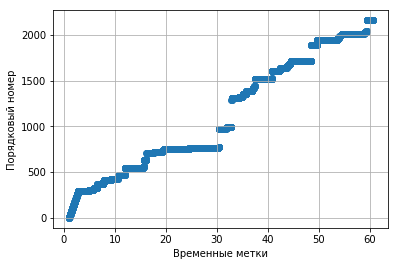

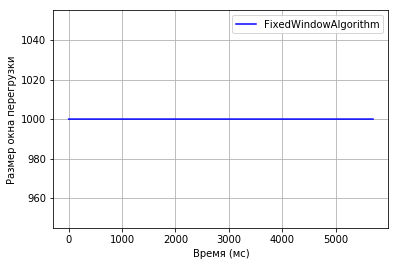

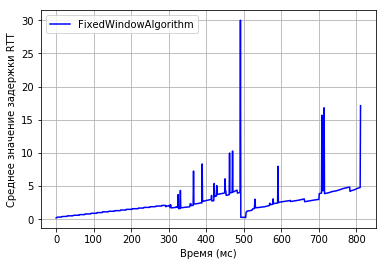

In [3]:
mah_settings = {
    'delay': 88,
    'queue_size': 26400,
    'trace_file': TRACE_FILES['2.64MBPS']
}

port = open_tcp_port()
run_mah_settings(mah_settings, 60, [Sender(port, FixedWindowAlgorithm(1000))])
# Функция run_mah_settings принимает некоторые параметры, такие как delay - задержка, queue_size - размер очереди и 
# trace_file - файлы, содержащие значения пропускной способности,
# а также кремя работы соединения в секундах , и алгоритм управления перегрузкой,
# Затем выводит некоторую статистику о состоянии сети,
# это достигается путем соединения отправителя и получателя, которые отправляют UDP-пакеты друг другу через сетевое приложение махимахи
# Это UDP-соединение, хотя на самом деле не является TCP,но является способом имитации работы TCP с условия сети и выбранным алгоритмом

# Контроль перегрузки в алгоритме Tahoe

TCP Tahoe - один из первых алгоритмов управления перегрузкой. Его реализация состоит из медленного старта и предотвращения перегрузки.

В фазе медленного старта, размер окна перегрузки `cwnd`, начинается с 1 и увеличивается на единицу при каждом подтверждении, которое получает отправитель. Как только размер окна перегрузки `cwnd` достигает некоторого настраиваемого порога, называемого "Порогом медленного старта", отправитель переходит в режим "предотвращения перегрузки", и размер окна `cwnd` увеличивается на 1 каждый раз, когда приходит подтверждение. Фактически это означает, что размер окна `cwnd` быстро растет во время медленного старта и медленнее во время фазы предотвращения перегрузки.
Если пакет потерян, TCP Tahoe выполняет фукнкцию "быстрого восстановления", в ней, потерянный пакет передается повторно, размер окна `cwnd` устанавливается в значение 1, а порог медленного старта обновляется до половины текущего значения окна перегрузки`cwnd`.

In [3]:
class TahoeAlgorithm(SenderAlgorithm):
    """Реализация алгоритма TCP Tahoe."""
    def __init__(self, slow_start_thresh: int, initial_cwnd: int) -> None:
        self.slow_start_thresh = slow_start_thresh # значение медленного старта

        self.cwnd = initial_cwnd # начальное значение окна перегрузки
        self.fast_retransmit_packet = None # пакет быстрой повторной передачи
        self.time_since_retransmit = None # время с момента повторной передачи
        self.retransmitting_packet = False # передача пакетов
        self.ack_count = 0

        self.duplicated_ack = None # дублирование ack
        self.slow_start_thresholds = [] # значение порога медленного старта

        super().__init__()

    def window_is_open(self) -> bool:
        """Открытие окна передачи."""
        # next_ack - порядковый номер следующего подтверждения, которое ожидает получатель. 
        # Если промежуток между next_ack и seq_num больше, чем у окна перегрузки, тогда нам нужно дождаться появления новых подтверждений.
        return self.seq_num - self.next_ack < self.cwnd

    def next_packet_to_send(self) -> Optional[str]:
        """Организация передачи."""
        send_data = None
        if self.retransmitting_packet and self.time_of_retransmit and time.time() - self.time_of_retransmit > 1:
            # Если время повторной передачи истекло, то отправление пакета происходит повторно
            self.retransmitting_packet = False

        if self.fast_retransmit_packet and not self.retransmitting_packet:
            # Логика повторной отправки пакета
            self.unacknowledged_packets[self.fast_retransmit_packet['seq_num']]['send_ts'] = time.time()
            send_data = self.fast_retransmit_packet
            serialized_data = json.dumps(send_data)
            self.retransmitting_packet = True

            self.time_of_retransmit = time.time()

        elif self.window_is_open():
            send_data = {
                'seq_num': self.seq_num,
                'send_ts': time.time()
            }

            self.unacknowledged_packets[self.seq_num] = send_data
            self.seq_num += 1
        else:
            # Проверяем, не истек ли тайм-аут каких-либо сегментов.
            # Традиционный TCP использует экспоненциальный откат для вычисления тайм-аутов
            for seq_num, segment in self.unacknowledged_packets.items():
                if time.time() - segment['send_ts'] > 4:
                    self.unacknowledged_packets[seq_num]['send_ts'] = time.time()
                    return json.dumps(segment)

        if send_data is None:
            return None
        else:
            return json.dumps(send_data)


    def process_ack(self, serialized_ack: str) -> None:
        """Реализация процесса передачи следующего пакета."""
        ack = json.loads(serialized_ack)
        if ack.get('handshake'):
            return

        self.total_acks += 1
        self.times_of_acknowledgements.append(((time.time() - self.start_time), ack['seq_num']))


        if self.unacknowledged_packets.get(ack['seq_num']) is None:
            # Дублирование ack

            self.num_duplicate_acks += 1
            if self.duplicated_ack and ack['seq_num'] == self.duplicated_ack['seq_num']:
                self.curr_duplicate_acks += 1
            else:
                self.duplicated_ack = ack
                self.curr_duplicate_acks = 1

            if self.curr_duplicate_acks == 3:
                # При получении 3 дублированных подтверждений возникает повторная передача
                self.fast_retransmit_packet = self.unacknowledged_packets[ack['seq_num'] + 1]
                self.slow_start_thresh = int(max(1, self.cwnd/2))
                self.cwnd = 1
        elif ack['seq_num'] >= self.next_ack:
            if self.fast_retransmit_packet:
                self.fast_retransmit_packet = None
                self.retransmitting_packet = False
                self.curr_duplicate_acks = 0
                self.seq_num = ack['seq_num'] + 1

            # Подтверждаем все пакеты, где seq_num <ack ['seq_num']
            self.unacknowledged_packets = {
                k:v
                for k,v in
                self.unacknowledged_packets.items()
                if k > ack['seq_num']
            }
            self.next_ack = max(self.next_ack, ack['seq_num'] + 1)
            self.ack_count += 1
            self.sent_bytes += ack['ack_bytes']
            rtt = float(time.time() - ack['send_ts'])
            self.rtts.append(rtt)
            self.rtt_recordings.append(rtt)
            self.timeout = rtt * 1.2
            if self.cwnd < self.slow_start_thresh:
                # В медленном старте
                self.cwnd += 1
            elif (ack['seq_num'] + 1) % self.cwnd == 0:
                # В контроле перегрузки
                self.cwnd += 1

        self.cwnds.append(self.cwnd)
        self.slow_start_thresholds.append(self.slow_start_thresh)

### Задержка полосы пропускания

BDP (задержка полосы пропускания) вычисляется как произведение задержки на пропускную способность канала. Пропускная способность или "ширинa" канала - это количество информации, которое может проходить через канал в данную секунду, а задержка или "длина" канала - это количество времени, которое требуется одному пакету, чтобы прошел путь от отправителя к получателю. BDP можно рассматривать как «объем» передаваемых данных. Канал используется оптимально, когда отправитель сохраняет количество байтов BDP, переданных в любой данный момент времени.
Основными параметрами, для определения эффективности алгоритма, являются пропускная способность (байт/с) и среднее значение времени распространения пакетов - RTT (мс).

## Низкая пропускная способность

В этом состоянии, параметры: delay (задержка) установлена равной 88 мс, trace_file (полоса пропускания) установлена на 2,64 мб/с, а queue_size (размер очереди) - BDP канала = 26,4 кб.

[Отправитель] Подключен к получателю: 100.64.0.26:37433

Результаты для отправителя 59115, с алгоритмом: TahoeAlgorithm
Всего Acks: 170241
Количество дубликатов Acks: 790
% дубликат acks: 0.464048
Пропускная способность (бит/с): 56457.333333
Среднее значение задержки RTT (мс): 347.240960




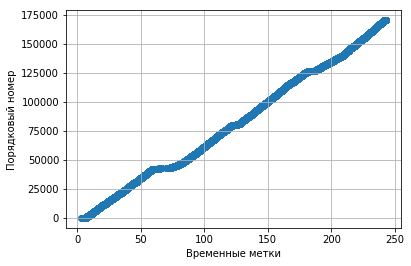

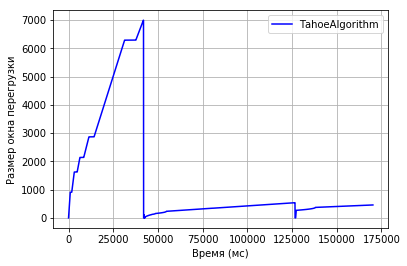

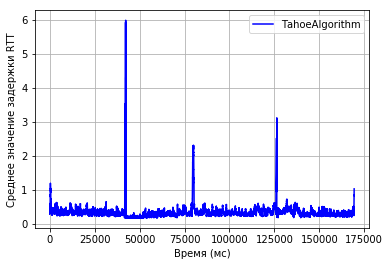

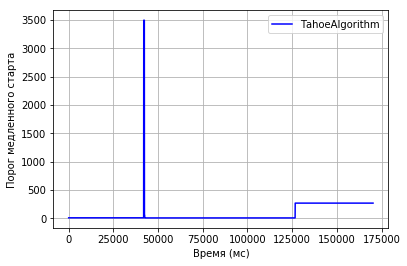

In [6]:
from src.algorithm import TahoeAlgorithm
mah_settings = {
    'delay': 88,
    'queue_size': 26400,
    'trace_file': TRACE_FILES['2.64MBPS']
}
# trace_file соответствует полосе пропускания
# delay (размер очереди) - задержка полосы пропускания (BDP) канала,
# которая представляет собой количество байтов, которое канал может разместить в любой данный момент времени
port = open_tcp_port()
run_mah_settings(mah_settings, 240, [Sender(port, TahoeAlgorithm(10, 1))])
# На графике, размер окна перегрузки падает довольно равномерно при размере окна = 600
# Канал может вместить 26400 байт

# Графики алгоритма Тахо имеют пилообразное поведение размера окна перегрузки, где оно некоторое время увеличивается,
# а потом снижается до 0,вследствии потери пакетов.

## Высокая пропускная способность

Аналогично примеру с низкой пропускной способностью, размер очереди устанавливается равным BDP канала. В отличие от настройки с низкой пропускной способностью, мы видим, что высокая пропускная способность приводит к большому значению размера окна перегрузки. Это демонстрирует, что даже, если канал способен отправлять больше пакетов, чем другой, то это не обязательно означает, что он может использовать полностью ресурсы канала.

In [ ]:
mah_settings = {
    'delay': 88,
    'queue_size': 1104620,
    'trace_file': TRACE_FILES['100.42MBPS']
}

port = open_tcp_port()
run_mah_settings(mah_settings, 240, [Sender(port, TahoeAlgorithm(10, 1))])

[Отправитель] Подключен к получателю: 100.64.0.36:48196



## Низкая пропускная способность с 2 фиксироваными окнами отправителя

При 2 отправитях (без контроля перегрузки), возникает конфликт и пропускная способность падает, в то время как с одним отправителем, пропускная способность составляет около 77 кб, здесь она падает до 400 б для каждого отправителя. Это связано с тем, что отправители не отбрасывают пакеты, отправляемые ими в ответ на перегрузку канала, они продолжают перегружать канал и вызывают дополнительную перегрузку.

[Отправитель] Подключен к получателю: 100.64.0.20:52876

[Отправитель] Подключен к получателю: 100.64.0.20:52876

Результаты для отправителя 43336, с алгоритмом: FixedWindowAlgorithm
Всего Acks: 2858
Количество дубликатов Acks: 2579
% дубликат acks: 90.237929
Пропускная способность (bytes/s): 372.000000
Среднее значение задержки RTT (ms): 1971.278805




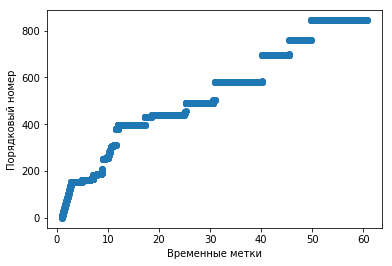

Результаты для отправителя 48754, с алгоритмом: FixedWindowAlgorithm
Всего Acks: 2796
Количество дубликатов Acks: 2555
% дубликат acks: 91.380544
Пропускная способность (bytes/s): 321.333333
Среднее значение задержки RTT (ms): 1731.914450




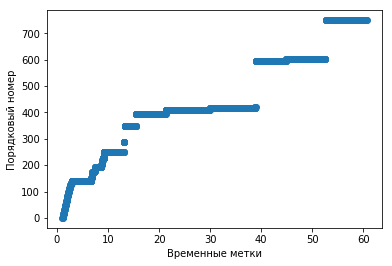

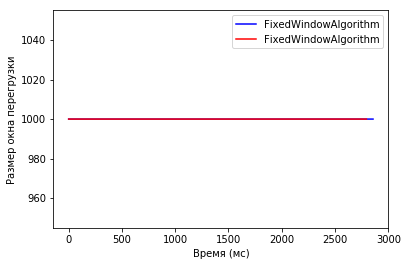

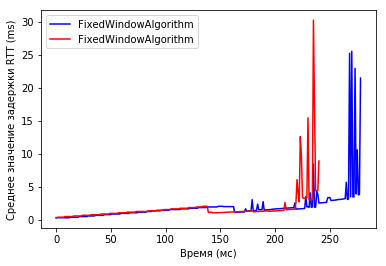

In [16]:
mah_settings = {
    'delay': 88,
    'queue_size': 26400,
    'trace_file': TRACE_FILES['2.64MBPS']
}

port = open_tcp_port()
port2 = open_tcp_port()
run_mah_settings(mah_settings, 60, [Sender(port, FixedWindowAlgorithm(1000)), Sender(port2, FixedWindowAlgorithm(1000))])

## Низкая пропускная способность с фиксированным окном и алгоритмом Тахо

В этом примере, мы помещаем отправителя с фиксированным окном в соединение с отправителем с алгоритмом Тахо. Отправитель с фиксированным окном захватывает весь канала и не дает отправить пакеты отправителя Тахо. Средний размер RTT отправителя Tahoe - 1730, потому что его пакеты застряли в очереди, и в итоге этот он пропустил только 7 пакетов за целую минуту.

[Отправитель] Подключен к получателю: 100.64.0.22:36090

[Отправитель] Подключен к получателю: 100.64.0.22:36090

Результаты для отправителя 59274, с алгоритмом: TahoeAlgorithm
Всего Acks: 7
Количество дубликатов Acks: 0
% дубликат acks: 0.000000
Пропускная способность (bytes/s): 9.333333
Среднее значение задержки RTT (ms): 1657.427107




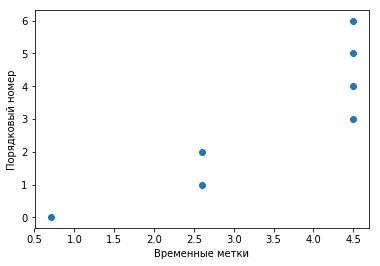

Результаты для отправителя 59598, с алгоритмом: FixedWindowAlgorithm
Всего Acks: 8658
Количество дубликатов Acks: 7689
% дубликат acks: 88.808039
Пропускная способность (bytes/s): 1292.000000
Среднее значение задержки RTT (ms): 1534.339670




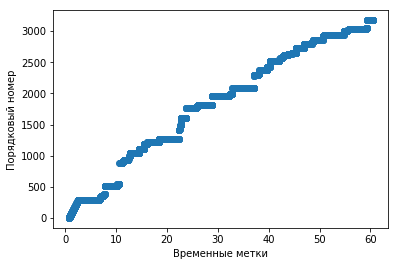

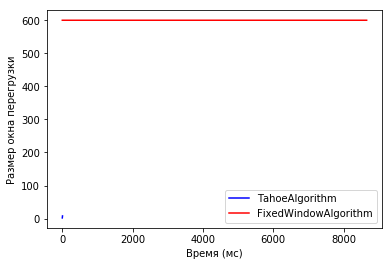

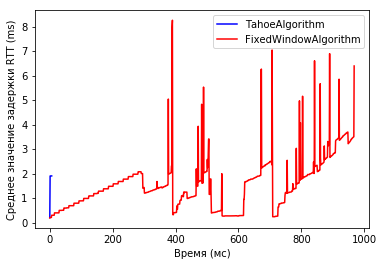

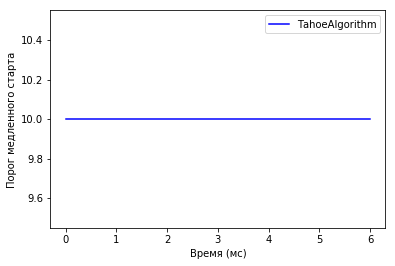

In [17]:
mah_settings = {
    'delay': 88,
    'queue_size': 26400,
    'trace_file': TRACE_FILES['2.64MBPS']
}

port = open_tcp_port()
port2 = open_tcp_port()
run_mah_settings(mah_settings, 60, [Sender(port, TahoeAlgorithm(10, 1)), Sender(port2, FixedWindowAlgorithm(600))])

## Низкая пропускная способность с 2 отправителя  с алгоритмом Тахо

В этом случае мы видем, что два отправителя Tahoe являются не конфликтными по отношению друг к другу, и каждый из них достигает пропускной способности, которая примерно равна половине того, что достигает один отправитель Tahoe по одному каналу.

[Отправитель] Подключен к получателю: 100.64.0.24:44170

[Отправитель] Подключен к получателю: 100.64.0.24:44170

Результаты для отправителя 57303, с алгоритмом: TahoeAlgorithm
Всего Acks: 52558
Количество дубликатов Acks: 1002
% дубликат acks: 1.906465
Пропускная способность (bytes/s): 34206.000000
Среднее значение задержки RTT (ms): 282.385555




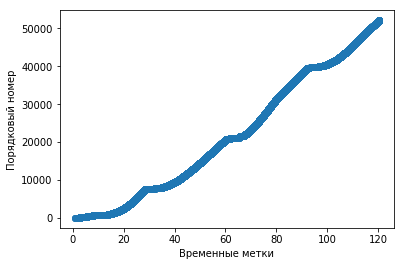

Результаты для отправителя 47446, с алгоритмом: TahoeAlgorithm
Всего Acks: 45104
Количество дубликатов Acks: 1091
% дубликат acks: 2.418854
Пропускная способность (bytes/s): 29183.333333
Среднее значение задержки RTT (ms): 284.288055




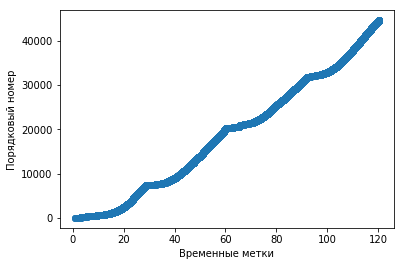

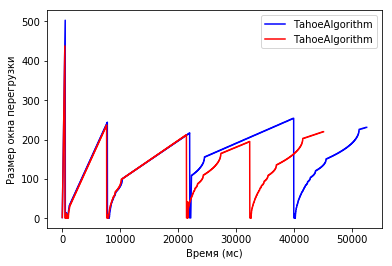

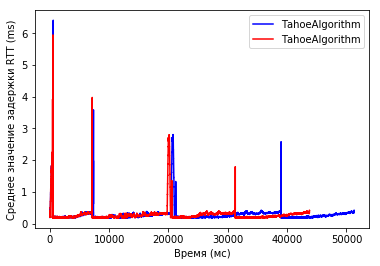

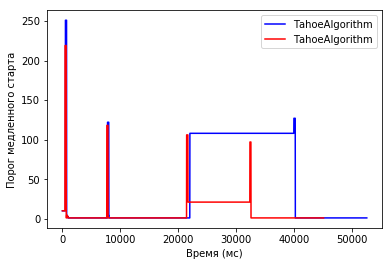

In [18]:
mah_settings = {
    'delay': 88,
    'queue_size': 26400,
    'trace_file': TRACE_FILES['2.64MBPS']
}

port = open_tcp_port()
port2 = open_tcp_port()
run_mah_settings(mah_settings, 120, [Sender(port, TahoeAlgorithm(10, 1)), Sender(port2, TahoeAlgorithm(10, 1))])

### Алгоритм Reno

TCP Reno был разработан в 1990 году. Особенностью данного алгоритма является циклическое изменение размера окна при нормальных условиях, пока не произойдет потеря сегмента. TCP Reno находится в фазе медленного старта, когда размер окна меньше определенного граничного значения числа сегментов, при котором происходит переход на фазу исключения перегрузки. В фазе медленного старта при получении квитанции, подтверждающей доставку, окно увеличивается на единицу. В фазе же исключения перегрузки в той же ситуации получения квитанции окно увеличивается на величину, обратную самому себе. Если во время таймаута удается обнаружить потерю сегмента, то пороговое число сегментов становится равным половине размера окна в данный момент, а размер окна становится равным единице (при использовании алгоритма быстрой повторной передачи размер окна становится равным новому пороговому числу сегментов). Сразу после этого происходит переход в фазу быстрого восстановления, в которой размер окна увеличивается на единицу только тогда, когда приходит дублированное подтверждение. Если же приходит недублированный отклик от сегмента, отправленного повторно, то размер окна становится равным пороговому числу сегментов. При таймауте в данной фазе значения размера окна и порогового числа сегментов обновляются, как при потере сегмента.

In [ ]:
mah_settings = {
    'delay': 88,
    'queue_size': 26400,
    'trace_file': TRACE_FILES['2.64MBPS']
}

port = open_tcp_port()
run_mah_settings(mah_settings, 240, [Sender(port, RenoAlgorithm(50, 1))])